11501568/11490434 [==============================] - 0s 0us/step
size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features

Train Accuracy: 0.9135
Number of Epoch = 1 - Average Cross Entropy:= 0.0038078347778320314 

Validation Accuracy: 0.9259

Train Accuracy: 0.9416
Number of Epoch = 2 - Average Cross Entropy:= 0.0016354017639160156 

Validation Accuracy: 0.9460

Train Accuracy: 0.9555
Number of Epoch = 3 - Average Cross Entropy:= 0.0012250753021240234 

Validation Accuracy: 0.9553

Train Accuracy: 0.9626
Number of Epoch = 4 - Average Cross Entropy:= 0.0009885480499267577 

Validation Accuracy: 0.9592

Train Accuracy: 0.9684
Number of Epoch = 5 - Average Cross Entropy:= 0.000827271728515625 

Validation Accuracy: 0.9624

Train Accuracy: 0.973

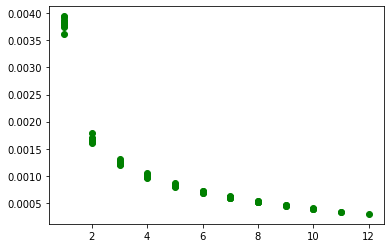

In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

cur_test_acc = []
for a in range(0,10):
  np.random.seed(a*9755)
  tf.random.set_seed(a*9755)

  tf.config.list_physical_devices('GPU')

  (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data() # Load MNIST or FMNIST
  assert X_train.shape == (60000, 28, 28)
  assert X_test.shape == (10000, 28, 28)
  assert y_train.shape == (60000,)
  assert y_test.shape == (10000,)

  # Split train dataset into train and validation
  X_val = X_train[50000:60000]
  X_train = X_train[0:50000]
  y_val = y_train[50000:60000]
  y_train = y_train[0:50000]

  print("size of training set is", str(X_train.shape[0]), "samples")
  print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

  print("size of validation set is", str(X_val.shape[0]), "samples")
  print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

  X_train = X_train.reshape(50000, 28*28)
  X_val = X_val.reshape(10000, 28*28)
  X_test = X_test.reshape(10000, 28*28)

  print("size of training set is", str(X_train.shape[0]), "samples")
  print("every train example has", str(X_train.shape[1]), "features")

  print("size of validation set is", str(X_val.shape[0]), "samples")
  print("every validation example has", str(X_val.shape[1]), "features")

  #Normalize Data

  X_train = X_train/255
  X_val = X_val/255
  X_test = X_test/255

  size_input = X_train.shape[1]
  size_hidden1 = 128
  size_hidden2 = 128
  size_hidden3 = 128
  size_output = 10

  number_of_train_examples = X_train.shape[0]
  number_of_test_examples = X_test.shape[0]

  y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
  y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
  y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

  mt = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ,0.0]
  vt = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ,0.0]
  ut = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ,0.0]

  def cubic_root(x):

    x = np.where(x>=0, x, -(-x)**(1.0/3.0))
    x = np.where(x<0, x, x**(1.0/3.0))

    return tf.Variable(x, dtype=tf.float32)

  # Define class to build mlp model
  class MLP(object):
    def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
      """
      size_input: int, size of input layer
      size_hidden1: int, size of the 1st hidden layer
      size_hidden2: int, size of the 2nd hidden layer
      size_output: int, size of output layer
      device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
      """
      self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
      size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
      
      # Initialize weights between input mapping and a layer g(f(x)) = layer
      self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
      # Initialize biases for hidden layer
      self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
      
      # Initialize weights between input layer and 1st hidden layer
      self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
      # Initialize biases for hidden layer
      self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
      
      # Initialize weights between 1st hidden layer and 2nd hidden layer
      self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
      # Initialize biases for hidden layer
      self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
      
      # Initialize weights between 2nd hidden layer and output layer
      self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
      # Initialize biases for output layer
      self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
      
      # Define variables to be updated during backpropagation
      self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
    
    def forward(self, X):
      """
      forward pass
      X: Tensor, inputs
      """
      if self.device is not None:
        with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output(X)
      else:
        self.y = self.compute_output(X)
        
      return self.y

    def loss(self, y_pred, y_true):
      '''
      y_pred - Tensor of shape (batch_size, size_output)
      y_true - Tensor of shape (batch_size, size_output)
      '''
      #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
      y_true_tf = tf.cast(y_true, dtype=tf.float32)
      y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
      cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
      loss_x = cce(y_true_tf, y_pred_tf)
      # Use keras or tf_softmax, both should work for any given model
      #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
      
      return loss_x

    def backward(self, X_train, y_train):
      """
      backward pass
      """
      optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
      
      with tf.GradientTape() as tape:
          
        predicted = self.forward(X_train)
        current_loss = self.loss(predicted, y_train)
          
      grads = tape.gradient(current_loss, self.variables)
      optimizer.apply_gradients(zip(grads, self.variables))
            
    def compute_output(self, X):
      """
      Custom method to obtain output tensor during forward pass
      """
      # Cast X to float32
      X_tf = tf.cast(X, dtype=tf.float32)
      #X_tf = X
      
      # Compute values in hidden layers
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      h1 = tf.nn.relu(z1)
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      h2 = tf.nn.relu(z2)
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      h3 = tf.nn.relu(z3)

      # Compute output
      output = tf.matmul(h3, self.W4) + self.b4
      
      #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
      # Second add tf.Softmax(output) and then return this variable
      return (output)

  # Set number of epochs
  NUM_EPOCHS = 20

  # Initialize model using CPU
  mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

  time_start = time.time()
  curr_loss_val = 100
  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(a*9755)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(inputs) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs)

    preds_val = mlp_on_cpu.forward(X_val)
    loss_val = mlp_on_cpu.loss(preds_val, y_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    if loss_val.numpy() > curr_loss_val:
      break
    
    W1 = mlp_on_cpu.variables[0]
    W2 = mlp_on_cpu.variables[1]
    W3 = mlp_on_cpu.variables[2]
    W4 = mlp_on_cpu.variables[3]
    b1 = mlp_on_cpu.variables[4]
    b2 = mlp_on_cpu.variables[5]
    b3 = mlp_on_cpu.variables[6]
    b4 = mlp_on_cpu.variables[7]

    curr_loss_val = loss_val.numpy()
    cur_val_acc = accuracy.numpy()

    preds = mlp_on_cpu.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))


    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

          
  time_taken = time.time() - time_start
      
  # Validate model
      


  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

  # Initialize
  mlp_on_cpu.variables[0].assign(W1)
  mlp_on_cpu.variables[1].assign(W2)
  mlp_on_cpu.variables[2].assign(W3)
  mlp_on_cpu.variables[3].assign(W4)
  mlp_on_cpu.variables[4].assign(b1)
  mlp_on_cpu.variables[5].assign(b2)
  mlp_on_cpu.variables[6].assign(b3)
  mlp_on_cpu.variables[7].assign(b4)

  test_loss_total = tf.Variable(0, dtype=tf.float32)
  correct_prediction = tf.Variable(0, dtype=tf.float32)


  test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


  #test_loss_total = 0.0
  for inputs, outputs in test_ds:
    preds = mlp_on_cpu.forward(inputs)
    test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

  # Test model
  preds_test = mlp_on_cpu.forward(X_test)
  preds_test = tf.nn.softmax(preds_test)
  correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_test_acc.append(accuracy.numpy())
  #print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))
print(cur_test_acc)

11501568/11490434 [==============================] - 0s 0us/step
size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features

Train Accuracy: 0.9106
Number of Epoch = 1 - Average Cross Entropy:= 0.012031722412109374 

Validation Accuracy: 0.9235

Train Accuracy: 0.9398
Number of Epoch = 2 - Average Cross Entropy:= 0.009539398193359375 

Validation Accuracy: 0.9443

Train Accuracy: 0.9528
Number of Epoch = 3 - Average Cross Entropy:= 0.008801327514648438 

Validation Accuracy: 0.9531

Train Accuracy: 0.9599
Number of Epoch = 4 - Average Cross Entropy:= 0.008249635620117187 

Validation Accuracy: 0.9589

Train Accuracy: 0.9641
Number of Epoch = 5 - Average Cross Entropy:= 0.007780906982421875 

Validation Accuracy: 0.9610

Train Accuracy: 0.9672
Nu

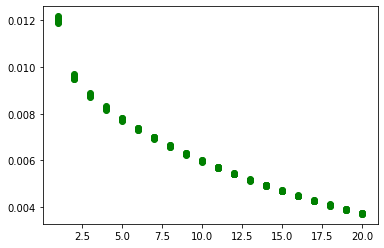

In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

cur_test_acc = []
for a in range(0,10):
  np.random.seed(a*9755)
  tf.random.set_seed(a*9755)

  tf.config.list_physical_devices('GPU')

  (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data() # Load MNIST or FMNIST
  assert X_train.shape == (60000, 28, 28)
  assert X_test.shape == (10000, 28, 28)
  assert y_train.shape == (60000,)
  assert y_test.shape == (10000,)

  # Split train dataset into train and validation
  X_val = X_train[50000:60000]
  X_train = X_train[0:50000]
  y_val = y_train[50000:60000]
  y_train = y_train[0:50000]

  print("size of training set is", str(X_train.shape[0]), "samples")
  print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

  print("size of validation set is", str(X_val.shape[0]), "samples")
  print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

  X_train = X_train.reshape(50000, 28*28)
  X_val = X_val.reshape(10000, 28*28)
  X_test = X_test.reshape(10000, 28*28)

  print("size of training set is", str(X_train.shape[0]), "samples")
  print("every train example has", str(X_train.shape[1]), "features")

  print("size of validation set is", str(X_val.shape[0]), "samples")
  print("every validation example has", str(X_val.shape[1]), "features")

  #Normalize Data

  X_train = X_train/255
  X_val = X_val/255
  X_test = X_test/255

  size_input = X_train.shape[1]
  size_hidden1 = 128
  size_hidden2 = 128
  size_hidden3 = 128
  size_output = 10

  number_of_train_examples = X_train.shape[0]
  number_of_test_examples = X_test.shape[0]

  y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
  y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
  y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

  mt = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ,0.0]
  vt = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ,0.0]
  ut = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ,0.0]

  def cubic_root(x):

    x = np.where(x>=0, x, -(-x)**(1.0/3.0))
    x = np.where(x<0, x, x**(1.0/3.0))

    return tf.Variable(x, dtype=tf.float32)

  # Define class to build mlp model
  class MLP(object):
    def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
      """
      size_input: int, size of input layer
      size_hidden1: int, size of the 1st hidden layer
      size_hidden2: int, size of the 2nd hidden layer
      size_output: int, size of output layer
      device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
      """
      self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
      size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
      
      # Initialize weights between input mapping and a layer g(f(x)) = layer
      self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
      # Initialize biases for hidden layer
      self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
      
      # Initialize weights between input layer and 1st hidden layer
      self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
      # Initialize biases for hidden layer
      self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
      
      # Initialize weights between 1st hidden layer and 2nd hidden layer
      self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
      # Initialize biases for hidden layer
      self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
      
      # Initialize weights between 2nd hidden layer and output layer
      self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
      # Initialize biases for output layer
      self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
      
      # Define variables to be updated during backpropagation
      self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
    
    def forward(self, X):
      """
      forward pass
      X: Tensor, inputs
      """
      if self.device is not None:
        with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output(X)
      else:
        self.y = self.compute_output(X)
        
      return self.y

    def loss(self, y_pred, y_true):
      '''
      y_pred - Tensor of shape (batch_size, size_output)
      y_true - Tensor of shape (batch_size, size_output)
      '''
      #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
      y_true_tf = tf.cast(y_true, dtype=tf.float32)
      y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
      cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
      regularizer = tf.reduce_sum(tf.abs(self.W1)) + tf.reduce_sum(tf.abs(self.W2))\
                  + tf.reduce_sum(tf.abs(self.W3))+ tf.reduce_sum(tf.abs(self.W4))/4.0  #L1 Regularization
      loss_x = cce(y_true_tf, y_pred_tf) + 0.0001*regularizer      
      # Use keras or tf_softmax, both should work for any given model
      #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
      
      return loss_x

    def backward(self, X_train, y_train):
      """
      backward pass
      """
      optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
      
      with tf.GradientTape() as tape:
          
        predicted = self.forward(X_train)
        current_loss = self.loss(predicted, y_train)
          
      grads = tape.gradient(current_loss, self.variables)
      optimizer.apply_gradients(zip(grads, self.variables))
            
    def compute_output(self, X):
      """
      Custom method to obtain output tensor during forward pass
      """
      # Cast X to float32
      X_tf = tf.cast(X, dtype=tf.float32)
      #X_tf = X
      
      # Compute values in hidden layers
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      h1 = tf.nn.relu(z1)
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      h2 = tf.nn.relu(z2)
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      h3 = tf.nn.relu(z3)

      # Compute output
      output = tf.matmul(h3, self.W4) + self.b4
      
      #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
      # Second add tf.Softmax(output) and then return this variable
      return (output)

  # Set number of epochs
  NUM_EPOCHS = 20

  # Initialize model using CPU
  mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

  time_start = time.time()
  curr_loss_val = 100
  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(a*9755)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(inputs) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs)

    preds_val = mlp_on_cpu.forward(X_val)
    loss_val = mlp_on_cpu.loss(preds_val, y_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    if loss_val.numpy() > curr_loss_val:
      break
    
    W1 = mlp_on_cpu.variables[0]
    W2 = mlp_on_cpu.variables[1]
    W3 = mlp_on_cpu.variables[2]
    W4 = mlp_on_cpu.variables[3]
    b1 = mlp_on_cpu.variables[4]
    b2 = mlp_on_cpu.variables[5]
    b3 = mlp_on_cpu.variables[6]
    b4 = mlp_on_cpu.variables[7]

    curr_loss_val = loss_val.numpy()
    cur_val_acc = accuracy.numpy()

    preds = mlp_on_cpu.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))


    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

          
  time_taken = time.time() - time_start
      
  # Validate model
      


  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

  # Initialize
  mlp_on_cpu.variables[0].assign(W1)
  mlp_on_cpu.variables[1].assign(W2)
  mlp_on_cpu.variables[2].assign(W3)
  mlp_on_cpu.variables[3].assign(W4)
  mlp_on_cpu.variables[4].assign(b1)
  mlp_on_cpu.variables[5].assign(b2)
  mlp_on_cpu.variables[6].assign(b3)
  mlp_on_cpu.variables[7].assign(b4)

  test_loss_total = tf.Variable(0, dtype=tf.float32)
  correct_prediction = tf.Variable(0, dtype=tf.float32)


  test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


  #test_loss_total = 0.0
  for inputs, outputs in test_ds:
    preds = mlp_on_cpu.forward(inputs)
    test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

  # Test model
  preds_test = mlp_on_cpu.forward(X_test)
  preds_test = tf.nn.softmax(preds_test)
  correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_test_acc.append(accuracy.numpy())
  #print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))
print(cur_test_acc)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features

Train Accuracy: 0.9100
Number of Epoch = 1 - Average Cross Entropy:= 0.01370971923828125 

Validation Accuracy: 0.9230

Train Accuracy: 0.9380
Number of Epoch = 2 - Average Cross Entropy:= 0.010293201904296875 

Validation Accuracy: 0.9441

Train Accuracy: 0.9510
Number of Epoch = 3 - Average Cross Entropy:= 0.008783858032226562 

Validation Accuracy: 0.9527

Train Accuracy: 0.9586
Number of Epoch = 4 - Average Cross Entropy:= 0.007607088012695312 

Validation Accuracy: 0.9588

Train Accuracy: 0.9639
Number of Epoch = 5 - Average Cross Entropy:= 0.006640975341796875 

Validation Accuracy: 0.9621

Train Accuracy: 0.9675
Number of Epoch = 6 - Average Cross Entropy:= 0.0058312567138671875 

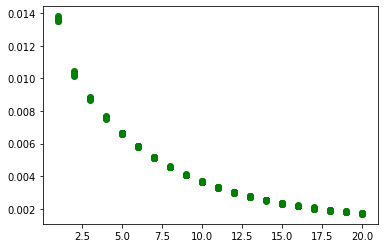

In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

cur_test_acc = []
for a in range(0,10):
  np.random.seed(a*9755)
  tf.random.set_seed(a*9755)

  tf.config.list_physical_devices('GPU')

  (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data() # Load MNIST or FMNIST
  assert X_train.shape == (60000, 28, 28)
  assert X_test.shape == (10000, 28, 28)
  assert y_train.shape == (60000,)
  assert y_test.shape == (10000,)

  # Split train dataset into train and validation
  X_val = X_train[50000:60000]
  X_train = X_train[0:50000]
  y_val = y_train[50000:60000]
  y_train = y_train[0:50000]

  print("size of training set is", str(X_train.shape[0]), "samples")
  print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

  print("size of validation set is", str(X_val.shape[0]), "samples")
  print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

  X_train = X_train.reshape(50000, 28*28)
  X_val = X_val.reshape(10000, 28*28)
  X_test = X_test.reshape(10000, 28*28)

  print("size of training set is", str(X_train.shape[0]), "samples")
  print("every train example has", str(X_train.shape[1]), "features")

  print("size of validation set is", str(X_val.shape[0]), "samples")
  print("every validation example has", str(X_val.shape[1]), "features")

  #Normalize Data

  X_train = X_train/255
  X_val = X_val/255
  X_test = X_test/255

  size_input = X_train.shape[1]
  size_hidden1 = 128
  size_hidden2 = 128
  size_hidden3 = 128
  size_output = 10

  number_of_train_examples = X_train.shape[0]
  number_of_test_examples = X_test.shape[0]

  y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
  y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
  y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

  mt = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ,0.0]
  vt = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ,0.0]
  ut = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ,0.0]

  def cubic_root(x):

    x = np.where(x>=0, x, -(-x)**(1.0/3.0))
    x = np.where(x<0, x, x**(1.0/3.0))

    return tf.Variable(x, dtype=tf.float32)

  # Define class to build mlp model
  class MLP(object):
    def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
      """
      size_input: int, size of input layer
      size_hidden1: int, size of the 1st hidden layer
      size_hidden2: int, size of the 2nd hidden layer
      size_output: int, size of output layer
      device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
      """
      self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
      size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
      
      # Initialize weights between input mapping and a layer g(f(x)) = layer
      self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
      # Initialize biases for hidden layer
      self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
      
      # Initialize weights between input layer and 1st hidden layer
      self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
      # Initialize biases for hidden layer
      self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
      
      # Initialize weights between 1st hidden layer and 2nd hidden layer
      self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
      # Initialize biases for hidden layer
      self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
      
      # Initialize weights between 2nd hidden layer and output layer
      self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
      # Initialize biases for output layer
      self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
      
      # Define variables to be updated during backpropagation
      self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
    
    def forward(self, X):
      """
      forward pass
      X: Tensor, inputs
      """
      if self.device is not None:
        with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output(X)
      else:
        self.y = self.compute_output(X)
        
      return self.y

    def loss(self, y_pred, y_true):
      '''
      y_pred - Tensor of shape (batch_size, size_output)
      y_true - Tensor of shape (batch_size, size_output)
      '''
      #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
      y_true_tf = tf.cast(y_true, dtype=tf.float32)
      y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
      cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
      regularizer = tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2))\
                  + tf.reduce_sum(tf.square(self.W3))+ tf.reduce_sum(tf.square(self.W4))/4.0  #L2 Regularization
      loss_x = cce(y_true_tf, y_pred_tf) + 0.001*regularizer      
      # Use keras or tf_softmax, both should work for any given model
      #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
      
      return loss_x

    def backward(self, X_train, y_train):
      """
      backward pass
      """
      optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
      
      with tf.GradientTape() as tape:
          
        predicted = self.forward(X_train)
        current_loss = self.loss(predicted, y_train)
          
      grads = tape.gradient(current_loss, self.variables)
      optimizer.apply_gradients(zip(grads, self.variables))
            
    def compute_output(self, X):
      """
      Custom method to obtain output tensor during forward pass
      """
      # Cast X to float32
      X_tf = tf.cast(X, dtype=tf.float32)
      #X_tf = X
      
      # Compute values in hidden layers
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      h1 = tf.nn.relu(z1)
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      h2 = tf.nn.relu(z2)
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      h3 = tf.nn.relu(z3)

      # Compute output
      output = tf.matmul(h3, self.W4) + self.b4
      
      #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
      # Second add tf.Softmax(output) and then return this variable
      return (output)

  # Set number of epochs
  NUM_EPOCHS = 20

  # Initialize model using CPU
  mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

  time_start = time.time()
  curr_loss_val = 100
  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(a*9755)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(inputs) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs)

    preds_val = mlp_on_cpu.forward(X_val)
    loss_val = mlp_on_cpu.loss(preds_val, y_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    if loss_val.numpy() > curr_loss_val:
      break
    
    W1 = mlp_on_cpu.variables[0]
    W2 = mlp_on_cpu.variables[1]
    W3 = mlp_on_cpu.variables[2]
    W4 = mlp_on_cpu.variables[3]
    b1 = mlp_on_cpu.variables[4]
    b2 = mlp_on_cpu.variables[5]
    b3 = mlp_on_cpu.variables[6]
    b4 = mlp_on_cpu.variables[7]

    curr_loss_val = loss_val.numpy()
    cur_val_acc = accuracy.numpy()

    preds = mlp_on_cpu.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))


    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

          
  time_taken = time.time() - time_start
      
  # Validate model
      


  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

  # Initialize
  mlp_on_cpu.variables[0].assign(W1)
  mlp_on_cpu.variables[1].assign(W2)
  mlp_on_cpu.variables[2].assign(W3)
  mlp_on_cpu.variables[3].assign(W4)
  mlp_on_cpu.variables[4].assign(b1)
  mlp_on_cpu.variables[5].assign(b2)
  mlp_on_cpu.variables[6].assign(b3)
  mlp_on_cpu.variables[7].assign(b4)

  test_loss_total = tf.Variable(0, dtype=tf.float32)
  correct_prediction = tf.Variable(0, dtype=tf.float32)


  test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


  #test_loss_total = 0.0
  for inputs, outputs in test_ds:
    preds = mlp_on_cpu.forward(inputs)
    test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

  # Test model
  preds_test = mlp_on_cpu.forward(X_test)
  preds_test = tf.nn.softmax(preds_test)
  correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_test_acc.append(accuracy.numpy())
  #print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))
print(cur_test_acc)